In [1]:
import pandas as pd

In [ ]:
df = pd.read_csv("data/restaurants_with_labels.csv")

In [4]:
df.iloc[:1]

,place_id,name,formatted_address,address_components,lat,lng,vicinity,types,business_status,rating,...,delivery,reservable,editorial_summary,reviews,photos,neighborhood,zipcode,reviews_text,cuisine,labels
0,ChIJBcwG1ZdKW4YR4H9Pg5TYwvU,Blenders & Bowls - Westlake,"3736 Bee Caves Rd Suite 8, West Lake Hills, TX...","[{""long_name"": ""Suite 8"", ""short_name"": ""Suite...",30.280914,-97.807242,"3736 Bee Caves Rd Suite 8, West Lake Hills","[""establishment"", ""food"", ""point_of_interest"",...",OPERATIONAL,4.2,...,True,False,Health-conscious cafe serving smoothies & acai...,"[{""rating"": 5, ""text"": ""My favorite place to g...","[{""photo_reference"": ""AciIO2ew_BLTCnbFrsWweBvb...",Las Brisas,78746,My favorite place to grab an acai bowl! The gi...,Health Food,"['Shelf', 'Fast food restaurant', 'Restaurant'..."


In [5]:
df.iloc[:1]['user_ratings_total']

0    98.0
Name: user_ratings_total, dtype: float64

In [6]:
df.columns

Index(['place_id', 'name', 'formatted_address', 'address_components', 'lat',
       'lng', 'vicinity', 'types', 'business_status', 'rating',
       'user_ratings_total', 'price_level', 'opening_hours_weekday_text',
       'opening_hours_periods', 'website', 'url', 'serves_beer', 'serves_wine',
       'dine_in', 'takeout', 'curbside_pickup', 'delivery', 'reservable',
       'editorial_summary', 'reviews', 'photos', 'neighborhood', 'zipcode',
       'reviews_text', 'cuisine', 'labels'],
      dtype='object')

In [7]:
# 1. Clean data - DROP RESTAURANTS WITH < 3 RATINGS
df_clean = df.dropna(subset=['rating', 'labels'])
df_clean = df_clean[df_clean['user_ratings_total'] >= 3]  # Changed from 10 to 3

# Standardize labels to lowercase
def standardize_labels(labels):
    if isinstance(labels, list):
        return [label.lower() for label in labels]
    elif isinstance(labels, str):
        return [label.lower() for label in eval(labels)]
    else:
        return []

df_clean['labels'] = df_clean['labels'].apply(standardize_labels)

print(f"Restaurants after filtering (>= 3 ratings): {len(df_clean)}")

Restaurants after filtering (>= 3 ratings): 2474


In [8]:
# 2. Define quartiles
q1 = df_clean['rating'].quantile(0.25)
q3 = df_clean['rating'].quantile(0.75)

bottom_quartile = df_clean[df_clean['rating'] <= q1].copy()
top_quartile = df_clean[df_clean['rating'] >= q3].copy()

print(f"Bottom Quartile: {len(bottom_quartile)} restaurants (rating <= {q1:.2f})")
print(f"Top Quartile: {len(top_quartile)} restaurants (rating >= {q3:.2f})")

Bottom Quartile: 637 restaurants (rating <= 4.20)
Top Quartile: 697 restaurants (rating >= 4.70)


In [9]:
# 3. Prepare labels for TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Convert list of labels to space-separated strings
# Labels are already lowercase from step 1
bottom_quartile['labels_text'] = bottom_quartile['labels'].apply(lambda x: ' '.join(x))
top_quartile['labels_text'] = top_quartile['labels'].apply(lambda x: ' '.join(x))

print(f"Bottom Quartile: {len(bottom_quartile)} restaurants (rating <= {q1:.2f})")
print(f"Top Quartile: {len(top_quartile)} restaurants (rating >= {q3:.2f})")

# Check it worked
print("\nSample labels_text:")
print(bottom_quartile['labels_text'].iloc[0])

Bottom Quartile: 637 restaurants (rating <= 4.20)
Top Quartile: 697 restaurants (rating >= 4.70)

Sample labels_text:
shelf fast food restaurant restaurant retail produce ingredient natural foods strawberry customer bowl advertising interior design cafeteria fruit food court countertop berry food tableware logo inn açaí na tigela restaurant menu


In [10]:
# 4. Compute TF-IDF
# Combine both for fitting
all_texts = pd.concat([bottom_quartile['labels_text'], top_quartile['labels_text']])

vectorizer = TfidfVectorizer(
    lowercase=False,
    tokenizer=lambda x: x.split(),  # Split on spaces to keep full labels intact
    token_pattern=None
)

vectorizer.fit(all_texts)

# Transform each quartile
tfidf_bottom = vectorizer.transform(bottom_quartile['labels_text'])
tfidf_top = vectorizer.transform(top_quartile['labels_text'])

print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())} unique labels")

Vocabulary size: 1344 unique labels


In [11]:
# 5. Compare TF-IDF scores between quartiles
avg_bottom = np.asarray(tfidf_bottom.mean(axis=0)).flatten()
avg_top = np.asarray(tfidf_top.mean(axis=0)).flatten()

feature_names = vectorizer.get_feature_names_out()

comparison_df = pd.DataFrame({
    'label': feature_names,
    'bottom_tfidf': avg_bottom,
    'top_tfidf': avg_top,
    'difference': avg_top - avg_bottom,
    'ratio': np.where(avg_bottom > 0, avg_top / avg_bottom, np.inf)
}).sort_values('difference', ascending=False)

print("="*80)
print("TOP LABELS FOR HIGH-RATED RESTAURANTS")
print("="*80)
print(comparison_df.head(20))

print("\n" + "="*80)
print("TOP LABELS FOR LOW-RATED RESTAURANTS")
print("="*80)
print(comparison_df.tail(20))

TOP LABELS FOR HIGH-RATED RESTAURANTS
             label  bottom_tfidf  top_tfidf  difference     ratio
1258         truck      0.024265   0.068649    0.044385  2.829194
847        outdoor      0.020584   0.043566    0.022981  2.116464
488           food      0.198728   0.218875    0.020147  1.101379
1191          taco      0.031926   0.050259    0.018333  1.574220
1284     vegetable      0.048112   0.062022    0.013911  1.289137
1155        street      0.008702   0.021795    0.013093  2.504629
485           foil      0.012111   0.024187    0.012076  1.997107
463         finger      0.041800   0.052792    0.010992  1.262955
376        dessert      0.013611   0.024562    0.010951  1.804583
665         korean      0.015128   0.025382    0.010254  1.677767
148          bread      0.018055   0.028267    0.010213  1.565648
916         picnic      0.002613   0.012807    0.010194  4.901462
106           beef      0.011018   0.020911    0.009893  1.897889
149      breakfast      0.024852   0.0

/var/folders/_6/0l1cj9313b14qttgyr_30fjc0000gn/T/ipykernel_53980/923528313.py:12: RuntimeWarning: divide by zero encountered in divide
  'ratio': np.where(avg_bottom > 0, avg_top / avg_bottom, np.inf)


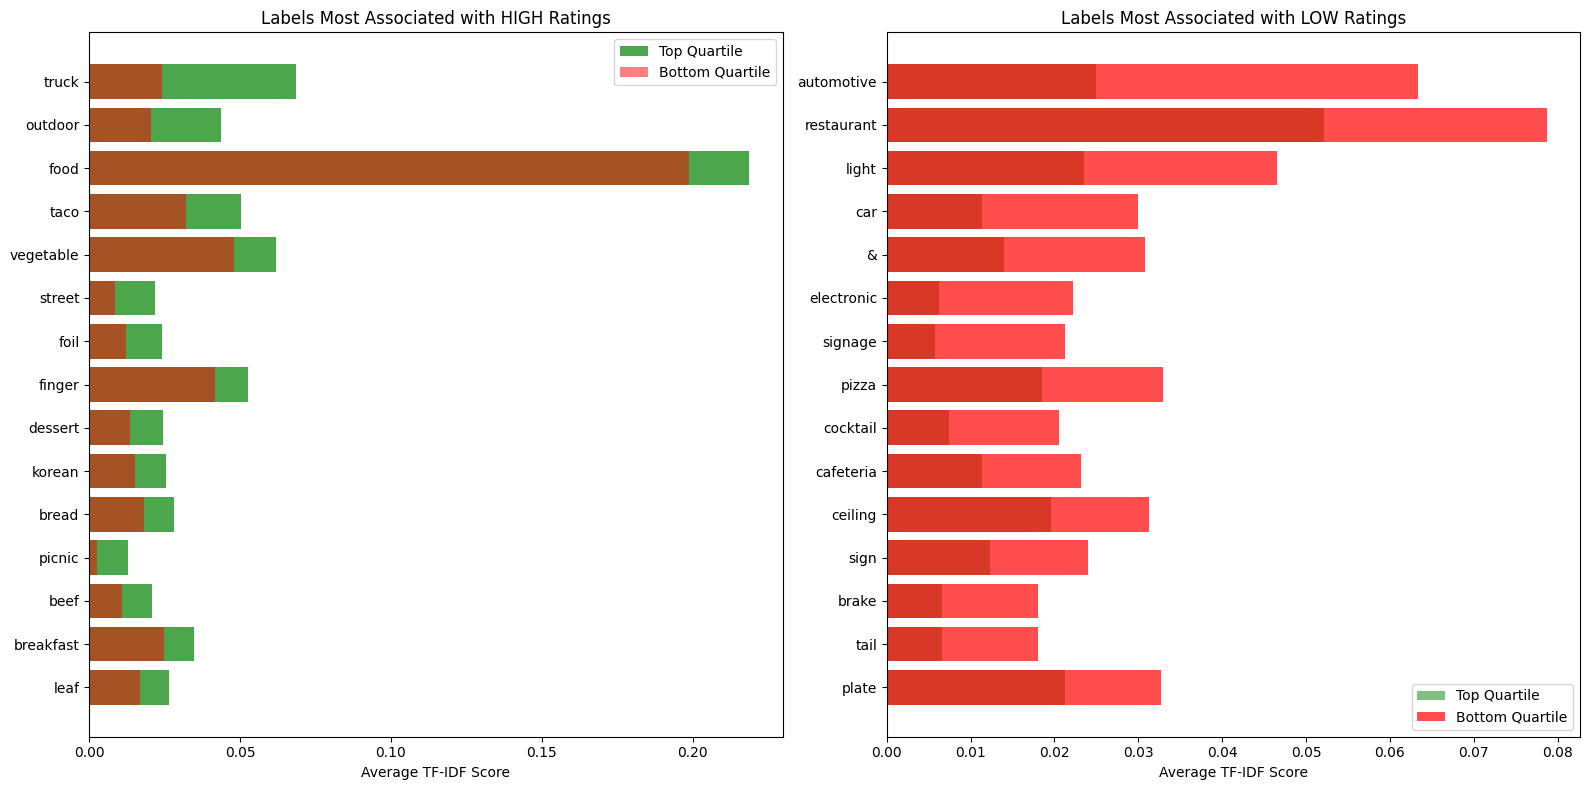

In [12]:
# 6. Visualize TF-IDF comparison
top_labels = comparison_df.nlargest(15, 'difference')
bottom_labels = comparison_df.nsmallest(15, 'difference')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# High-rated labels
ax1.barh(range(len(top_labels)), top_labels['top_tfidf'], color='green', alpha=0.7, label='Top Quartile')
ax1.barh(range(len(top_labels)), top_labels['bottom_tfidf'], color='red', alpha=0.5, label='Bottom Quartile')
ax1.set_yticks(range(len(top_labels)))
ax1.set_yticklabels(top_labels['label'])
ax1.set_xlabel('Average TF-IDF Score')
ax1.set_title('Labels Most Associated with HIGH Ratings')
ax1.legend()
ax1.invert_yaxis()

# Low-rated labels
ax2.barh(range(len(bottom_labels)), bottom_labels['top_tfidf'], color='green', alpha=0.5, label='Top Quartile')
ax2.barh(range(len(bottom_labels)), bottom_labels['bottom_tfidf'], color='red', alpha=0.7, label='Bottom Quartile')
ax2.set_yticks(range(len(bottom_labels)))
ax2.set_yticklabels(bottom_labels['label'])
ax2.set_xlabel('Average TF-IDF Score')
ax2.set_title('Labels Most Associated with LOW Ratings')
ax2.legend()
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [13]:
# 7. Cosine Similarity Analysis
print("="*80)
print("COSINE SIMILARITY ANALYSIS")
print("="*80)

# Within bottom quartile
sim_bottom = cosine_similarity(tfidf_bottom)
np.fill_diagonal(sim_bottom, np.nan)
avg_sim_bottom = np.nanmean(sim_bottom)

# Within top quartile
sim_top = cosine_similarity(tfidf_top)
np.fill_diagonal(sim_top, np.nan)
avg_sim_top = np.nanmean(sim_top)

# Between groups
sim_between = cosine_similarity(tfidf_bottom, tfidf_top)
avg_sim_between = np.mean(sim_between)

print(f"\nAverage Cosine Similarity WITHIN Bottom Quartile: {avg_sim_bottom:.4f}")
print(f"Average Cosine Similarity WITHIN Top Quartile: {avg_sim_top:.4f}")
print(f"Average Cosine Similarity BETWEEN Quartiles: {avg_sim_between:.4f}")

# Statistical test
within_bottom_vals = sim_bottom[~np.isnan(sim_bottom)]
within_top_vals = sim_top[~np.isnan(sim_top)]

t_stat, p_val = stats.ttest_ind(within_top_vals, within_bottom_vals)
print(f"\nT-test (Top vs Bottom within-group similarity):")
print(f"  t-statistic: {t_stat:.4f}, p-value: {p_val:.4e}")

if avg_sim_top > avg_sim_bottom:
    print("  → Top-rated restaurants are MORE similar to each other (more consistent)")
else:
    print("  → Top-rated restaurants are LESS similar to each other (more diverse)")

COSINE SIMILARITY ANALYSIS

Average Cosine Similarity WITHIN Bottom Quartile: 0.1250
Average Cosine Similarity WITHIN Top Quartile: 0.1288
Average Cosine Similarity BETWEEN Quartiles: 0.1208

T-test (Top vs Bottom within-group similarity):
  t-statistic: 15.7477, p-value: 7.2440e-56
  → Top-rated restaurants are MORE similar to each other (more consistent)


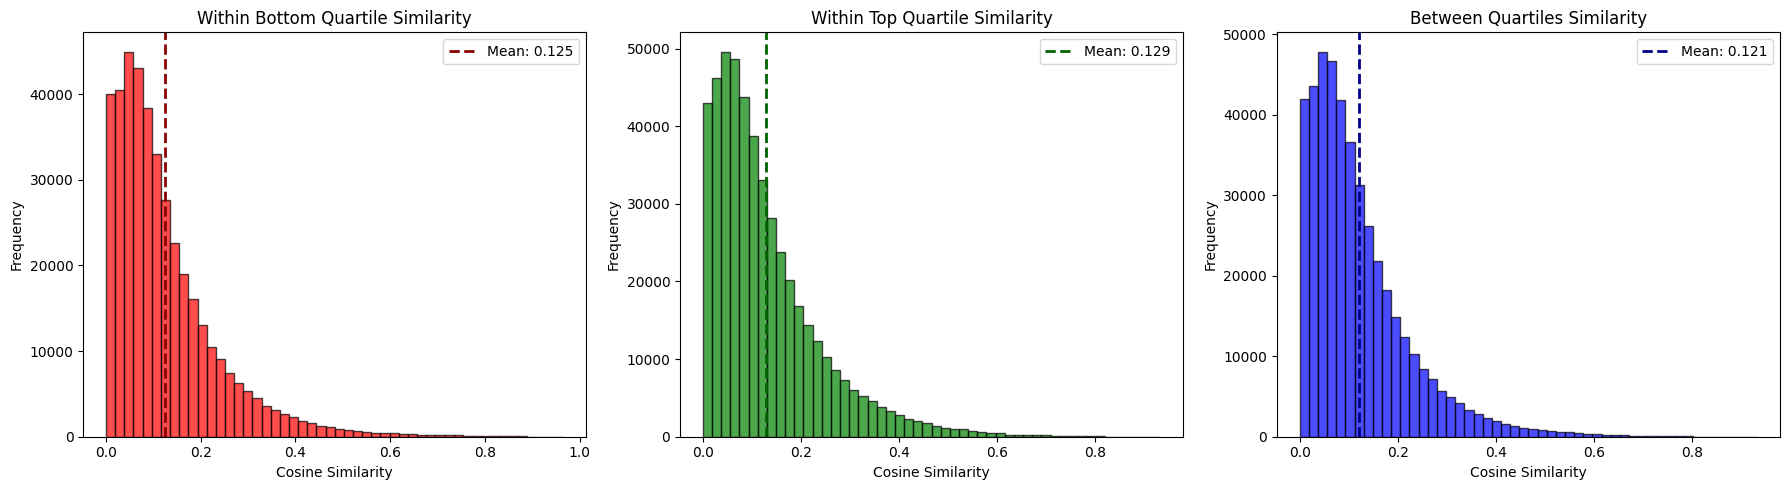

In [14]:
# 8. Visualize similarity distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Within bottom
axes[0].hist(within_bottom_vals, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0].axvline(avg_sim_bottom, color='darkred', linestyle='--', linewidth=2, label=f"Mean: {avg_sim_bottom:.3f}")
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Within Bottom Quartile Similarity')
axes[0].legend()

# Within top
axes[1].hist(within_top_vals, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(avg_sim_top, color='darkgreen', linestyle='--', linewidth=2, label=f"Mean: {avg_sim_top:.3f}")
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Within Top Quartile Similarity')
axes[1].legend()

# Between groups
axes[2].hist(sim_between.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[2].axvline(avg_sim_between, color='darkblue', linestyle='--', linewidth=2, label=f"Mean: {avg_sim_between:.3f}")
axes[2].set_xlabel('Cosine Similarity')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Between Quartiles Similarity')
axes[2].legend()

plt.tight_layout()
plt.show()

In [15]:
# 9. BONUS: Label Lift Analysis (FIXED)
from collections import Counter

# Flatten the labels properly
all_labels_bottom = []
for labels in bottom_quartile['labels']:
    if isinstance(labels, list):
        all_labels_bottom.extend(labels)
    elif isinstance(labels, str):
        all_labels_bottom.extend(eval(labels))

all_labels_top = []
for labels in top_quartile['labels']:
    if isinstance(labels, list):
        all_labels_top.extend(labels)
    elif isinstance(labels, str):
        all_labels_top.extend(eval(labels))

counts_bottom = Counter(all_labels_bottom)
counts_top = Counter(all_labels_top)

n_bottom = len(bottom_quartile)
n_top = len(top_quartile)

all_labels = set(counts_bottom.keys()) | set(counts_top.keys())

lift_data = []
for label in all_labels:
    prob_bottom = counts_bottom.get(label, 0) / n_bottom
    prob_top = counts_top.get(label, 0) / n_top
    
    if prob_bottom > 0:
        lift = prob_top / prob_bottom
    else:
        lift = np.inf if prob_top > 0 else 1.0
    
    lift_data.append({
        'label': label,
        'count_bottom': counts_bottom.get(label, 0),
        'count_top': counts_top.get(label, 0),
        'prob_bottom': prob_bottom,
        'prob_top': prob_top,
        'lift': lift
    })

lift_df = pd.DataFrame(lift_data).sort_values('lift', ascending=False)
lift_df = lift_df[(lift_df['count_bottom'] >= 5) | (lift_df['count_top'] >= 5)]

print("="*80)
print("LABELS WITH HIGHEST LIFT (associated with high ratings)")
print("="*80)
print(lift_df.head(20))

print("\n" + "="*80)
print("LABELS WITH LOWEST LIFT (associated with low ratings)")
print("="*80)
print(lift_df.tail(20))

LABELS WITH HIGHEST LIFT (associated with high ratings)
                     label  count_bottom  count_top  prob_bottom  prob_top  \
1043        home appliance             0          6      0.00000  0.008608   
379           health shake             0         12      0.00000  0.017217   
655             wheat beer             0          5      0.00000  0.007174   
708              tarpaulin             0          5      0.00000  0.007174   
1                  cortado             0          5      0.00000  0.007174   
861              churrasco             0          5      0.00000  0.007174   
1236             chocolate             0          6      0.00000  0.008608   
183             cappuccino             0          5      0.00000  0.007174   
92                   glaze             0          6      0.00000  0.008608   
212                 waffle             0          5      0.00000  0.007174   
169              tv dinner             1         13      0.00157  0.018651   
808     

---

## Now by cuisine

In [16]:
# Get most common cuisines
cuisine_counts = df_clean['cuisine'].value_counts()
print("Top 10 cuisines:")
print(cuisine_counts.head(10))

# Pick cuisines with enough data (e.g., at least 50 restaurants)
top_cuisines = cuisine_counts[cuisine_counts >= 50].index.tolist()

print(f"\nAnalyzing {len(top_cuisines)} cuisines with sufficient data")

Top 10 cuisines:
cuisine
Mexican          735
American         403
Bar              214
Italian          145
Japanese         106
Chinese           94
Cafe              90
Indian            88
Mediterranean     82
Latin             72
Name: count, dtype: int64

Analyzing 12 cuisines with sufficient data


In [17]:
# Compare TF-IDF by cuisine
cuisine_results = {}

for cuisine in top_cuisines[:5]:  # Analyze top 5 cuisines
    print(f"\n{'='*80}")
    print(f"CUISINE: {cuisine}")
    print(f"{'='*80}")
    
    # Filter by cuisine
    cuisine_df = df_clean[df_clean['cuisine'] == cuisine].copy()
    
    # Get quartiles for this cuisine
    q1_c = cuisine_df['rating'].quantile(0.25)
    q3_c = cuisine_df['rating'].quantile(0.75)
    
    bottom_c = cuisine_df[cuisine_df['rating'] <= q1_c].copy()  # Added .copy()
    top_c = cuisine_df[cuisine_df['rating'] >= q3_c].copy()      # Added .copy()
    
    print(f"Bottom quartile: {len(bottom_c)} restaurants (rating <= {q1_c:.2f})")
    print(f"Top quartile: {len(top_c)} restaurants (rating >= {q3_c:.2f})")
    
    if len(bottom_c) < 10 or len(top_c) < 10:
        print("Insufficient data, skipping...")
        continue
    
    # Prepare labels
    bottom_c['labels_text'] = bottom_c['labels'].apply(
        lambda x: ' '.join(x) if isinstance(x, list) else ' '.join(eval(x)) if isinstance(x, str) else ''
    )
    top_c['labels_text'] = top_c['labels'].apply(
        lambda x: ' '.join(x) if isinstance(x, list) else ' '.join(eval(x)) if isinstance(x, str) else ''
    )
    
    # TF-IDF for this cuisine
    all_texts_c = pd.concat([bottom_c['labels_text'], top_c['labels_text']])
    
    vectorizer_c = TfidfVectorizer(lowercase=False, tokenizer=lambda x: x.split(), token_pattern=None)
    vectorizer_c.fit(all_texts_c)
    
    tfidf_bottom_c = vectorizer_c.transform(bottom_c['labels_text'])
    tfidf_top_c = vectorizer_c.transform(top_c['labels_text'])
    
    # Compare
    avg_bottom_c = np.asarray(tfidf_bottom_c.mean(axis=0)).flatten()
    avg_top_c = np.asarray(tfidf_top_c.mean(axis=0)).flatten()
    
    comparison_c = pd.DataFrame({
        'label': vectorizer_c.get_feature_names_out(),
        'bottom_tfidf': avg_bottom_c,
        'top_tfidf': avg_top_c,
        'difference': avg_top_c - avg_bottom_c
    }).sort_values('difference', ascending=False)
    
    print("\nTop 10 labels for HIGH-rated restaurants:")
    print(comparison_c.head(10)[['label', 'difference']].to_string(index=False))
    
    print("\nTop 10 labels for LOW-rated restaurants:")
    print(comparison_c.tail(10)[['label', 'difference']].to_string(index=False))
    
    cuisine_results[cuisine] = comparison_c


CUISINE: Mexican
Bottom quartile: 232 restaurants (rating <= 4.20)
Top quartile: 226 restaurants (rating >= 4.70)

Top 10 labels for HIGH-rated restaurants:
    label  difference
    truck    0.058867
     taco    0.048193
     food    0.046243
     foil    0.039408
  outdoor    0.032978
vegetable    0.028493
   korean    0.027326
aluminium    0.021353
  produce    0.019495
     leaf    0.017554

Top 10 labels for LOW-rated restaurants:
     label  difference
  lighting   -0.015209
electronic   -0.015521
   fixture   -0.015554
   ceiling   -0.017105
         &   -0.020573
  cocktail   -0.024515
restaurant   -0.026406
       car   -0.026626
     light   -0.033019
automotive   -0.058119

CUISINE: American
Bottom quartile: 140 restaurants (rating <= 4.30)
Top quartile: 106 restaurants (rating >= 4.70)

Top 10 labels for HIGH-rated restaurants:
    label  difference
    truck    0.036459
  outdoor    0.032163
vegetable    0.018582
     food    0.016829
 roasting    0.016702
    pizza    0